[1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0
 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1
 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0
 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1
 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1
 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0

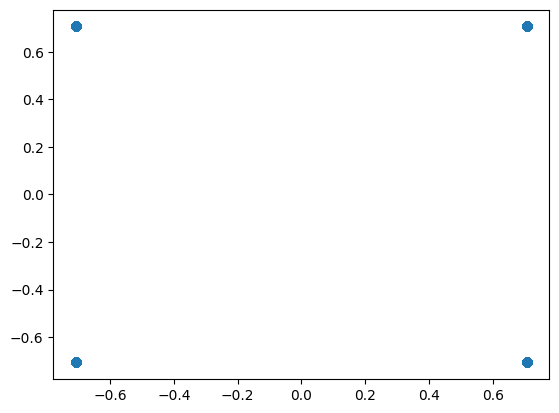

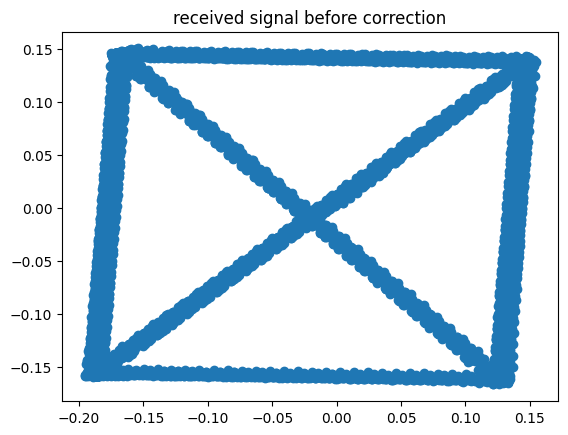

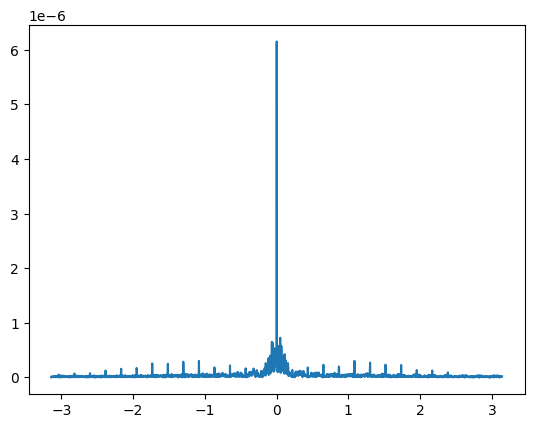

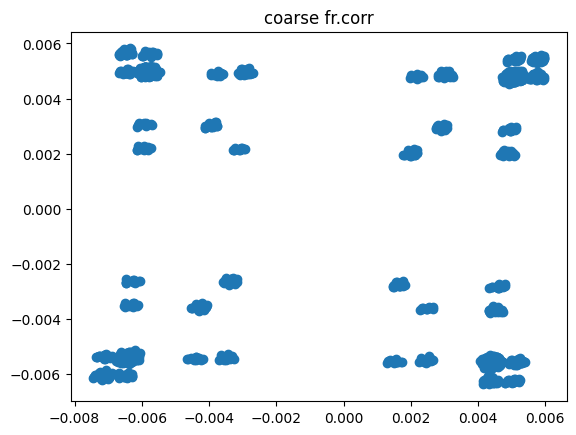

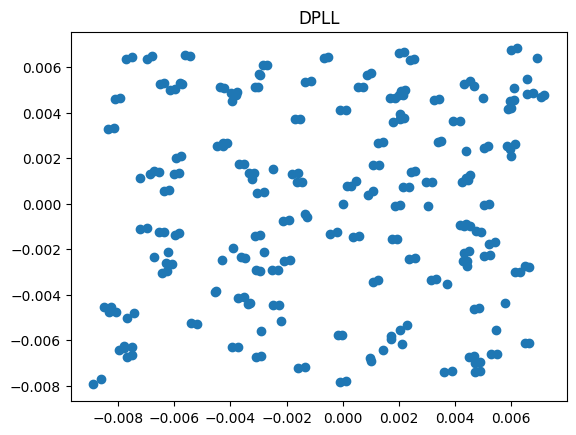

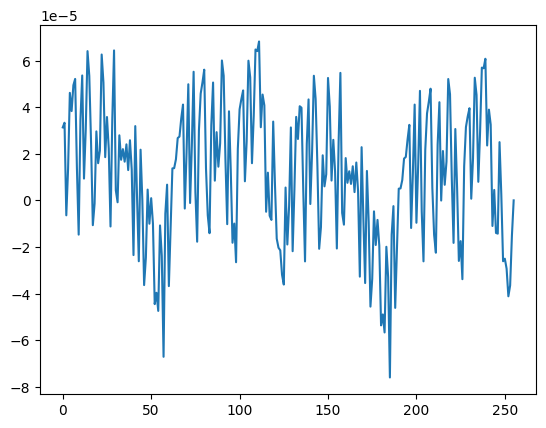

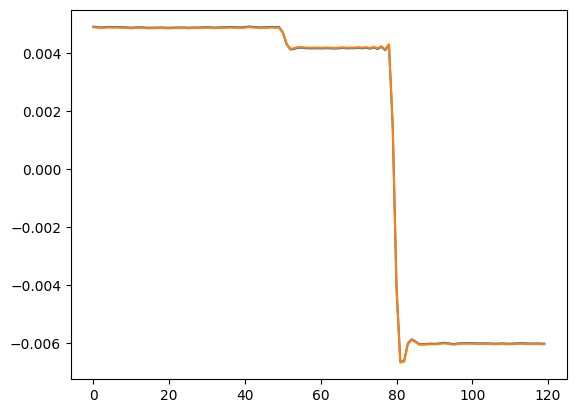

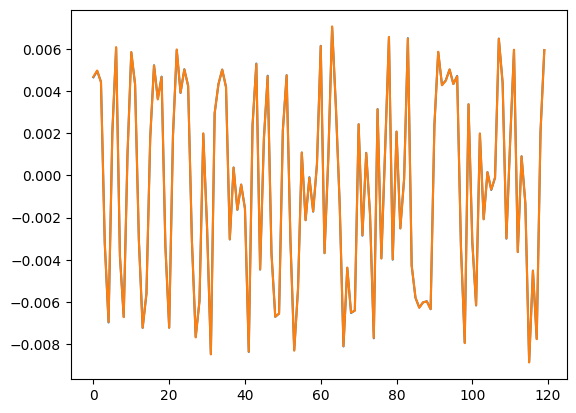

In [4]:

import adi
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import max_len_seq
from scipy import fftpack

sdr = adi.Pluto('ip:192.168.2.1')
sdr.sample_rate = 3000000
sdr.tx_destroy_buffer()
 

sdr.rx_lo = int(900e6)
sdr.tx_lo = int(900e6)
sdr.tx_cyclic_buffer = True
#sdr.tx_cyclic_buffer = False
sdr.tx_hardwaregain_chan0 = -5
sdr.gain_control_mode_chan0 = "fast_attack"

def sqrt_rc_imp(ns, alpha, m):
    n = np.arange(-m * ns, m * ns + 1)
    b = np.zeros(len(n))
    ns *= 1.0
    a = alpha
    for i in range(len(n)):
       #if abs(1 - 16 * a ** 2 * (n[i] / ns) ** 2) <= np.finfo(np.float32).eps/2:
        #   b[i] = 1/2.*((1+a)*np.sin((1+a)*np.pi/(4.*a))-(1-a)*np.cos((1-a)*np.pi/(4.*a))+(4*a)/np.pi*np.sin((1-a)*np.pi/(4.*a)))
       #else:
           b[i] = 4*a/(np.pi * (1 - 16 * a ** 2 * (n[i] / ns) ** 2))
           b[i] = b[i]*(np.cos((1+a) * np.pi * n[i] / ns) + np.sinc((1 - a) * n[i] / ns) * (1 - a) * np.pi / (4. * a))
    return b    

fs = sdr.sample_rate
rs=100000
ns=fs//rs
 

data=max_len_seq(8)[0]
print(data)
data = np.concatenate((data,np.zeros(1)))
print(data)
 
 
x_ = np.array([1,1,1,-1,-1,-1,1,-1,-1,1,-1])
b7=np.array([1,-1,1,1,1,-1,1])
ts1 =np.array([0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1])
ts2 =[0,0,1,0,1,1,0,1,1,1,0,1,1,1,1,0,0,0,1,0,1,1,0,1,1,1]
ts3 =[1,0,1,0,0,1,1,1,1,1,0,1,1,0,0,0,1,0,1,0,0,1,1,1,1,1]
ts4 =[1,1,1,0,1,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,1,1,1,0,0]
m=2*data-1
print(m)
#ts1t=2*ts1-1
ts1t=b7
b1 = sqrt_rc_imp(ns,0.35,4) 

b = np.ones(int(ns))
 
 
 
x=np.reshape(m,(2,128))
xi=x[0,:]
xq=x[1,:]
x_bb=(xi+1j*xq)/np.sqrt(2)
N_input = len(x_bb)
xup = np.hstack((x_bb.reshape(N_input,1),np.zeros((N_input, int(ns-1)))))
xup= xup.flatten()
x1 = signal.lfilter(b, 1,xup) 

plt.figure(1)
#plt.scatter(x_bb.real,x_bb.imag)
plt.scatter(x1.real,x1.imag)
 
xiq=2**14*x1
 
n_frame= len(xiq)
sdr.tx(xiq)

sdr.rx_rf_bandwidth = 1000000
sdr.rx_destroy_buffer()
sdr.rx_hardwaregain_chan0 = -5
sdr.rx_buffer_size =2*n_frame
xrec1=sdr.rx()
#sdr.tx_destroy_buffer()
xrec = xrec1/np.mean(xrec1**2)
xrecf=np.convolve(xrec ,b)
plt.figure(2)
plt.scatter(xrecf.real,xrecf.imag)
plt.title('received signal before correction')


xf1=np.fft.fft(xrec**4,2048) # возводим в 4 степень отсчеты сигнала и вычисляем ДПФ
K=2*np.pi*np.linspace(-0.5,0.5,2048) # ось нормированных частот 
plt.figure(3)
plt.plot(K, np.abs(np.fft.fftshift(xf1)))
arg=np.argmax(np.fft.fftshift(xf1)) #находим индекс с максимальной амплитудой
offf=K[arg]/4 # грубое смещение частоты в рад/отсчет 

xrec_coarse=xrec*np.exp(-1j*offf) # коррекция 
plt.figure(4)
plt.scatter(xrec_coarse.real,xrec_coarse.imag)
plt.title('coarse fr.corr')
print(offf)

xrec_coarse_d=signal.decimate(xrec_coarse,ns)
iter=2*n_frame

iter=256
phi1 = np.zeros(iter) # фаза на выходе петли PLL для коррекции сигнала
s_loop =  np.zeros(iter, dtype = complex)
dds_mult =  np.zeros(iter, dtype = complex)
phi_error =  np.zeros(iter)
phi_error_filtered =  np.zeros(iter)

phi1[0]=offf

int_out = 0
Kp = 0.005 # коэффициент пропорциональности 
Ki=0.001 #оэффициент интегратора 

iter=256
for i in range(iter-1):
    s_loop[i]=np.exp(1j*phi1[i])
    dds_mult[i]=xrec_coarse_d[i]*np.conjugate(s_loop[i])
    #dds_mult[i]=xrec[i]*np.conjugate(s_loop[i])# 
    phi_error[i]=np.imag(dds_mult[i]) # фазовая ошибка 
    #phi_error[i]=np.imag(xrec[i])*np.real(s_loop[i])-np.real(xrec[i])*np.imag(s_loop[i])
    #phi_error[i]=np.angle(dds_mult[i])
    prop_out = phi_error[i]*Kp
    int_out = phi_error[i]*Ki+int_out
    phi_error_filtered[i]=prop_out+int_out
    phi1[i+1]=phi1[i]+phi_error_filtered[i]
    
#xrecc=xrec_coarse_d*np.exp(-1j*phi1)
xrecc=xrec_coarse_d*s_loop
plt.figure(5)
plt.scatter(xrecc.real,xrecc.imag)
plt.title('DPLL')

plt.figure(6)
plt.plot(phi_error_filtered)   
 
plt.figure(7)
plt.plot(np.arange(0,120),np.real(xrec[0:120]),np.arange(0,120),np.real(xrec_coarse[0:120]))
    
plt.figure(8)    
plt.plot(np.arange(0,120),np.real(xrec_coarse_d[0:120]),np.arange(0,120),np.real(xrecc[0:120]))    

 




 

